In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from lgan.diffeomorphism import tf_diffeomorphism

In [2]:
batch_size = 32 #batch size
input_dim = 100 #dim x and z input_size

#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#simple plot function
def plot(samples, labels):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(4, 8)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig

In [4]:
'''
#try Diffeomorphism
image = numberImages
image = np.reshape(image, (10,28,28,1))
print(image.shape)
session = tf.InteractiveSession()
diff_map =  np.random.uniform(-0.6,0.6, size=(10,2, 2, 2)) #batch_size, diff_height, diff_width, 2
dif_image = tf_diffeomorphism(image,diff_map)
plot(image,np.zeros(10))
div_image = dif_image.eval()
plot(div_image,np.ones(10))
'''

'\n#try Diffeomorphism\nimage = numberImages\nimage = np.reshape(image, (10,28,28,1))\nprint(image.shape)\nsession = tf.InteractiveSession()\ndiff_map =  np.random.uniform(-0.6,0.6, size=(10,2, 2, 2)) #batch_size, diff_height, diff_width, 2\ndif_image = tf_diffeomorphism(image,diff_map)\nplot(image,np.zeros(10))\ndiv_image = dif_image.eval()\nplot(div_image,np.ones(10))\n'

In [5]:
#get Mean Image for Dif Input
def getMeanImage(batch_size,label):
    images = np.zeros((batch_size,784))
    for i in range(batch_size):      
        l = np.argwhere(label[i]==1)
        index = l[0][0]
        images[i]= np.reshape(numberImages[index],784)
    return images

In [6]:
#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,10)) 
    for i in range(batch_size):
        vector = np.random.uniform(-1., 1., size=[input_dim]) #create noise vector of 100
        index = int(np.random.rand(1)*10)
        labels[i][index]= 1  #get random label 
        batch[i] = vector
    return (batch, labels)

In [7]:
def generator(z,class_z,mean_image):
    with tf.variable_scope('generator'):
        mean_image = tf.reshape(mean_image,[batch_size, 28,28,1])
        class_z = slim.fully_connected(class_z, 128,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        class_z = tf.nn.relu(class_z)
        z = slim.fully_connected(z, 128,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        class_z = tf.nn.relu(z)
        add = tf.add(z,class_z)
        add = tf.reshape(add,[batch_size,16,8,1])
        net = slim.conv2d(add, 32, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_1',padding = 'SAME')  
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        print(net.shape)
        net = slim.conv2d(net, 1, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_2',padding = 'SAME')
        dif_paras = tf.nn.tanh(net)
        dif_paras= tf.reshape(dif_paras, [batch_size,2,2,2])
        print("Diffeo. Paras: ",dif_paras)
        print("Mean_Image: ",mean_image)
        dif_image = tf_diffeomorphism(mean_image,dif_paras) 
        return dif_image


def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[batch_size,28,28,1])
        #net = slim.conv2d(x, 128, [3, 3], weights_initializer=tf.contrib.layers.xavier_initializer(), scope='convD_1')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(x, 32, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_2',padding = 'SAME')
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 64, [3, 3],1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.convolution2d_transpose(net, 32, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_4',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 16, [3,3],1, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_5',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        return slim.fully_connected(net, num_outputs = 1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1))


In [8]:
#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#input
Mean_image = tf.placeholder(tf.float32, shape=[batch_size, 784])
X = tf.placeholder(tf.float32, shape=[batch_size,784]) 
Z = tf.placeholder(tf.float32, shape=[batch_size, input_dim]) #random Noise 100
Class_z = tf.placeholder(tf.float32, shape=[batch_size, 10]) #class(label) of image
print(Class_z)

#Models
dif_image = generator(Z, Class_z, Mean_image) #Generator generate image
D_real = discriminator(X)
D_fake = discriminator(dif_image)

#variables V1
theta_D1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(-D_loss, var_list=theta_D1))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(G_loss, var_list=theta_G1))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D1]


if not os.path.exists('out/'):
    os.makedirs('out/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

Tensor("Placeholder_3:0", shape=(32, 10), dtype=float32)
(32, 8, 4, 32)
Diffeo. Paras:  Tensor("generator/Reshape_2:0", shape=(32, 2, 2, 2), dtype=float32)
Mean_Image:  Tensor("generator/Reshape:0", shape=(32, 28, 28, 1), dtype=float32)


Pretrain Step  0 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  1 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  2 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  3 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  4 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  5 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  6 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  7 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  8 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  9 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  10 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  11 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 784)
Pretrain Step  12 X  (32, 784) z  (32, 100) z_class  (32, 10) mean  (32, 7

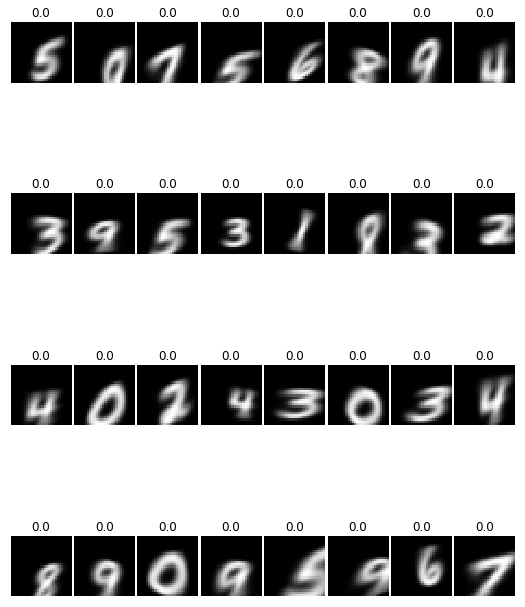

Iter: 100; D loss: 0.05538; G_loss: -0.003002
Iter: 200; D loss: 0.05727; G_loss: -0.002592
Iter: 300; D loss: 0.05722; G_loss: -0.003485
Iter: 400; D loss: 0.05806; G_loss: -0.003708
Iter: 500; D loss: 0.05873; G_loss: -0.002804
Iter: 600; D loss: 0.05865; G_loss: -0.003076
Iter: 700; D loss: 0.05912; G_loss: -0.002559
Iter: 800; D loss: 0.05914; G_loss: -0.002885
Iter: 900; D loss: 0.05808; G_loss: -0.003355
Iter: 1000; D loss: 0.05932; G_loss: -0.002724
(28, 28)


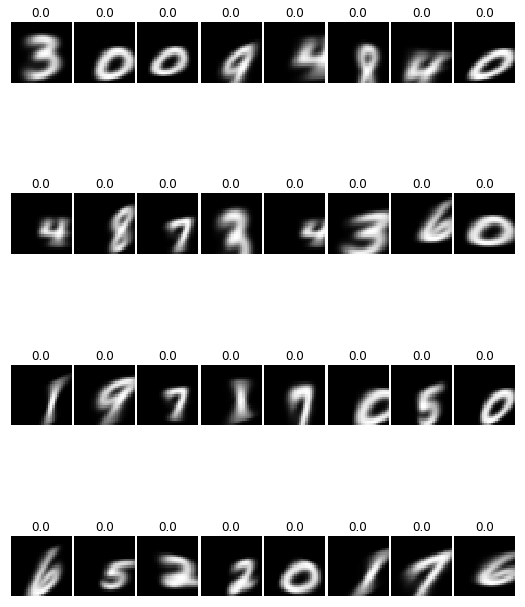

Iter: 1100; D loss: 0.05948; G_loss: -0.002931
Iter: 1200; D loss: 0.05957; G_loss: -0.002723
Iter: 1300; D loss: 0.05916; G_loss: -0.00265


KeyboardInterrupt: 

In [9]:
#pretrain disc:
for t in range(100):
    #train discriminator
    Xdata, _ = mnist.train.next_batch(batch_size)
    (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
    mean_image = getMeanImage(batch_size, class_z) #get mean_image
    print("Pretrain Step ",t,"X ",Xdata.shape,"z ",z.shape,"z_class ",class_z.shape,"mean ",mean_image.shape)
    _, D_loss_curr, _ = sess.run(
        [D_solver, D_loss, clip_D],
        feed_dict={X: Xdata, Z:z, Class_z:class_z, Mean_image:mean_image}
    ) 
    
i = 0
for it in range(100000):
    for _ in range(5): #train discriminator
        Xdata, _ = mnist.train.next_batch(batch_size)
        (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: Xdata, Z:z, Class_z:class_z, Mean_image:mean_image}
        )
    (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
    mean_image = getMeanImage(batch_size,class_z) #get mean_image
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image}
    )

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        if it % 1000 == 0:
            (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
            mean_image = getMeanImage(batch_size,class_z) #get mean_image
            samples = sess.run(dif_image, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image})         
            samples = np.reshape(samples, (batch_size,28,28))
            print(samples[0].shape)
            fig = plot(samples, np.zeros(batch_size))
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
plt.close(fig)